In [385]:
import warnings
warnings.filterwarnings('ignore')

In [386]:
import numpy as np
import time
from numba import njit,guvectorize,float64
import scipy.optimize as opt
from matplotlib import pyplot as plt
import iplotter

In [387]:
#Parameters

fosslim = 6000 # Maximum cumulative extraction fossil fuels (GtC); denoted by CCum
tstep  = 5 # Years per timesteps
nsteps = 40 # Number of timesteps, starting from 2000
ifopt  = 0 # Indicator where optimized is 1 and base is 0

In [388]:
#Preferences

elasmu = 1.45 #  Elasticity of marginal utility of consumption
prstp = 0.015 #   Initial rate of social time preference per year 

#** Emissions parameters
gsigma1  = -0.0152 # Initial growth of sigma (per year)            /-0.0152/
dsig  = -0.001 #   Decline rate of decarbonization (per period)    /-0.001 /
eland0 = 2.6 #  Carbon emissions from land 2015 (GtCO2 per year)   / 2.6   /
deland = 0.115 # Decline rate of land emissions (per period)        / .115  /
e0 = 35.85 #    Industrial emissions 2015 (GtCO2 per year)       /35.85  /
miu0  = 0.03 #   Initial emissions control rate for base case 2015  /.03    /

#** Carbon cycle
#* Initial Conditions
mat0 = 851 #  Initial Concentration in atmosphere 2015 (GtC)       /851  /
mu0  = 460 #  Initial Concentration in upper strata 2015 (GtC)     /460  /
ml0  = 1740 #  Initial Concentration in lower strata 2015 (GtC)    /1740 /
mateq = 588 # mateq Equilibrium concentration atmosphere  (GtC)    /588  /
mueq  = 360 # mueq Equilibrium concentration in upper strata (GtC) /360  /
mleq = 1720 # mleq Equilibrium concentration in lower strata (GtC) /1720 /

#* Flow paramaters, denoted by Phi_ij in the model
b12  = 0.12 #    Carbon cycle transition matrix                     /.12  /
b23  = 0.007 #   Carbon cycle transition matrix                    /0.007/
#* These are for declaration and are defined later
b11  = None   # Carbon cycle transition matrix
b21  = None  # Carbon cycle transition matrix
b22  = None  # Carbon cycle transition matrix
b32  = None  # Carbon cycle transition matrix
b33  = None  # Carbon cycle transition matrix
sig0  = None  # Carbon intensity 2010 (kgCO2 per output 2005 USD 2010)

#** Climate model parameters
t2xco2  = 3.1 # Equilibrium temp impact (oC per doubling CO2)    / 3.1 /
fex0  = 0.5 #   2015 forcings of non-CO2 GHG (Wm-2)              / 0.5 /
fex1  = 1.0 #   2100 forcings of non-CO2 GHG (Wm-2)              / 1.0 /
tocean0  = 0.0068 # Initial lower stratum temp change (C from 1900) /.0068/
tatm0  = 0.85 #  Initial atmospheric temp change (C from 1900)    /0.85/
c1  = 0.1005 #     Climate equation coefficient for upper level  /0.1005/
c3  = 0.088 #     Transfer coefficient upper to lower stratum    /0.088/
c4  = 0.025 #     Transfer coefficient for lower level           /0.025/
fco22x  = 3.6813 # eta in the model; Eq.22 : Forcings of equilibrium CO2 doubling (Wm-2)   /3.6813 /

#** Climate damage parameters
a10  = 0 #     Initial damage intercept                         /0   /
a20  = None #     Initial damage quadratic term
a1  = 0 #      Damage intercept                                 /0   /
a2  = 0.00236 #      Damage quadratic term                     /0.00236/
a3  = 2.00 #      Damage exponent                              /2.00   /

#** Abatement cost
expcost2 = 2.6 # Theta2 in the model, Eq. 10 Exponent of control cost function             / 2.6  /
pback  = 550 #   Cost of backstop 2010$ per tCO2 2015          / 550  /
gback  = 0.025 #   Initial cost decline backstop cost per period / .025/
limmiu  = 1.2 #  Upper limit on control rate after 2150        / 1.2 /
tnopol  = 45 #  Period before which no emissions controls base  / 45   /
cprice0  = 2 # Initial base carbon price (2010$ per tCO2)      / 2    /
gcprice  = 0.02 # Growth rate of base carbon price per year     /.02  /

#** Scaling and inessential parameters
#* Note that these are unnecessary for the calculations
#* They ensure that MU of first period's consumption =1 and PV cons = PV utilty
scale1  = 0.0302455265681763 #    Multiplicative scaling coefficient           /0.0302455265681763 /
scale2  = -10993.704 #    Additive scaling coefficient       /-10993.704/;

#* Parameters for long-run consistency of carbon cycle 
#(Question)
b11 = 1 - b12
b21 = b12*mateq/mueq
b22 = 1 - b21 - b23
b32 = b23*mueq/mleq
b33 = 1 - b32

#* Further definitions of parameters
a20 = a2
sig0 = e0/(q0*(1-miu0)) #From Eq. 14
lam = fco22x/ t2xco2 #From Eq. 25

In [389]:
#Set
t = np.arange(1, nsteps+1)
NT = len(t)

l = np.zeros(NT)
l[0] = pop0 #Labor force
al = np.zeros(NT) 
al[0] = a0
gsig = np.zeros(NT) 
gsig[0] = gsigma1
sigma = np.zeros(NT)
sigma[0]= sig0
ga = ga0 * np.exp(-dela*5*(t-1)) #TFP growth rate dynamics, Eq. 7
pbacktime = pback * (1-gback)**(t-1) #Backstop price
etree = eland0*(1-deland)**(t-1) #Emissions from deforestration
rr = 1/((1+prstp)**(tstep*(t-1))) #Eq. 3
#The following three equations define the exogenous radiative forcing; used in Eq. 23  
forcoth = np.full(NT,fex0)
forcoth[0:18] = forcoth[0:18] + (1/17)*(fex1-fex0)*(t[0:18]-1)
forcoth[18:NT] = forcoth[18:NT] + (fex1-fex0)
optlrsav = (dk + .004)/(dk + .004*elasmu + prstp)*gama #Optimal long-run savings rate used for transversality (Question)
cost1 = np.zeros(NT)
cumetree = np.zeros(NT)
cumetree[0] = 100
cpricebase = cprice0*(1+gcprice)**(5*(t-1)) 

In [390]:
@njit('(float64[:], int32)')
def InitializeLabor(il,iNT):
    for i in range(1,iNT):
        il[i] = il[i-1]*(popasym / il[i-1])**popadj

@njit('(float64[:], int32)')        
def InitializeTFP(ial,iNT):
    for i in range(1,iNT):
        ial[i] = ial[i-1]/(1-ga[i-1])
        
@njit('(float64[:], int32)')        
def InitializeGrowthSigma(igsig,iNT):
    for i in range(1,iNT):
        igsig[i] = igsig[i-1]*((1+dsig)**tstep)
        
@njit('(float64[:], float64[:],float64[:],int32)')        
def InitializeSigma(isigma,igsig,icost1,iNT):
    for i in range(1,iNT):
        isigma[i] =  isigma[i-1] * np.exp(igsig[i-1] * tstep)
        icost1[i] = pbacktime[i] * isigma[i]  / expcost2 /1000
        
@njit('(float64[:], int32)')        
def InitializeCarbonTree(icumetree,iNT):
    for i in range(1,iNT):
        icumetree[i] = icumetree[i-1] + etree[i-1]*(5/3.666)

In [391]:
"""
Functions of the model
"""

"""
First: Functions related to emissions of carbon and weather damages
"""

# Retuns the total carbon emissions; Eq. 18
@njit('float64(float64[:],int32)') 
def fE(iEIND,index):
    return iEIND[index] + etree[index]

#Eq.14: Determines the emission of carbon by industry EIND
@njit('float64(float64[:],float64[:],float64[:],int32)') 
def fEIND(iYGROSS, iMIU, isigma,index):
    return isigma[index] * iYGROSS[index] * (1 - iMIU[index])

#Cumulative industrial emission of carbon
@njit('float64(float64[:],float64[:],int32)') 
def fCCA(iCCA,iEIND,index):
    return iCCA[index-1] + iEIND[index-1] * 5 / 3.666

#Cumulative total carbon emission
@njit('float64(float64[:],float64[:],int32)')
def fCCATOT(iCCA,icumetree,index):
    return iCCA[index] + icumetree[index]

#Eq. 22: the dynamics of the radiative forcing
@njit('float64(float64[:],int32)')
def fFORC(iMAT,index):
    return fco22x * np.log(iMAT[index]/588.000)/np.log(2) + forcoth[index]

# Dynamics of Omega; Eq.9
@njit('float64(float64[:],int32)')
def fDAMFRAC(iTATM,index):
    return a1*iTATM[index] + a2*iTATM[index]**a3

#Calculate damages as a function of Gross industrial production; Eq.8 
@njit('float64(float64[:],float64[:],int32)')
def fDAMAGES(iYGROSS,iDAMFRAC,index):
    return iYGROSS[index] * iDAMFRAC[index]

#Dynamics of Lambda; Eq. 10 - cost of the reudction of carbon emission (Abatement cost)
@njit('float64(float64[:],float64[:],float64[:],int32)') 
def fABATECOST(iYGROSS,iMIU,icost1,index):
    return iYGROSS[index] * icost1[index] * iMIU[index]**expcost2

#Marginal Abatement cost
@njit('float64(float64[:],int32)')
def fMCABATE(iMIU,index):
    return pbacktime[index] * iMIU[index]**(expcost2-1)

#Price of carbon reduction
@njit('float64(float64[:],int32)')
def fCPRICE(iMIU,index):
    return pbacktime[index] * (iMIU[index])**(expcost2-1)

#Eq. 19: Dynamics of the carbon concentration in the atmosphere
@njit('float64(float64[:],float64[:],float64[:],int32)') 
def fMAT(iMAT,iMU,iE,index):
    if(index == 0):
        return mat0
    else:
        return iMAT[index-1]*b11 + iMU[index-1]*b21 + iE[index-1] * 5 / 3.666

#Eq. 21: Dynamics of the carbon concentration in the ocean LOW level
@njit('float64(float64[:],float64[:],int32)') 
def fML(iML,iMU,index):
    if(index == 0):
        return ml0
    else:
        return iML[index-1] * b33  + iMU[index-1] * b23

#Eq. 20: Dynamics of the carbon concentration in the ocean UP level
@njit('float64(float64[:],float64[:],float64[:],int32)') 
def fMU(iMAT,iMU,iML,index):
    if(index == 0):
        return mu0
    else:
        return iMAT[index-1]*b12 + iMU[index-1]*b22 + iML[index-1]*b32

#Eq. 23: Dynamics of the atmospheric temperature
@njit('float64(float64[:],float64[:],float64[:],int32)') 
def fTATM(iTATM,iFORC,iTOCEAN,index):
    if(index == 0):
        return tatm0
    else:
        return iTATM[index-1] + c1 * (iFORC[index] - (fco22x/t2xco2) * iTATM[index-1] - c3 * (iTATM[index-1] - iTOCEAN[index-1]))

#Eq. 24: Dynamics of the ocean temperature
@njit('float64(float64[:],float64[:],int32)')
def fTOCEAN(iTATM,iTOCEAN,index):
    if(index == 0):
        return tocean0
    else:
        return iTOCEAN[index-1] + c4 * (iTATM[index-1] - iTOCEAN[index-1])

"""
Second: Function related to economic variables
"""

#The total production without climate losses denoted previously by YGROSS
@njit('float64(float64[:],float64[:],float64[:],int32)')
def fYGROSS(ial,il,iK,index):
    return ial[index] * ((il[index]/1000)**(1-gama)) * iK[index]**gama

#The production under the climate damages cost
@njit('float64(float64[:],float64[:],int32)')
def fYNET(iYGROSS, iDAMFRAC, index):
    return iYGROSS[index] * (1 - iDAMFRAC[index])

#Production after abatement cost
@njit('float64(float64[:],float64[:],int32)')
def fY(iYNET,iABATECOST,index):
    return iYNET[index] - iABATECOST[index]

#Consumption Eq. 11
@njit('float64(float64[:],float64[:],int32)')
def fC(iY,iI,index):
    return iY[index] - iI[index]

#Per capita consumption, Eq. 12
@njit('float64(float64[:],float64[:],int32)')
def fCPC(iC,il,index):
    return 1000 * iC[index] / il[index]

#Saving policy: investment
@njit('float64(float64[:],float64[:],int32)')
def fI(iS,iY,index):
    return iS[index] * iY[index] 

#Capital dynamics Eq. 13
@njit('float64(float64[:],float64[:],int32)')
def fK(iK,iI,index):
    if(index == 0):
        return k0
    else:
        return (1-dk)**tstep * iK[index-1] + tstep * iI[index-1]

#Interest rate equation; Eq. 26 added in personal notes
@njit('float64(float64[:],int32)')
def fRI(iCPC,index):
    return (1 + prstp) * (iCPC[index+1]/iCPC[index])**(elasmu/tstep) - 1

#Periodic utility: A form of Eq. 2
@njit('float64(float64[:],float64[:],int32)')
def fCEMUTOTPER(iPERIODU,il,index):
    return iPERIODU[index] * il[index] * rr[index]

#The term between brackets in Eq. 2
@njit('float64(float64[:],float64[:],int32)')
def fPERIODU(iC,il,index):
    return ((iC[index]*1000/il[index])**(1-elasmu) - 1) / (1 - elasmu) - 1

#utility function
@guvectorize([(float64[:], float64[:])], '(n), (m)')
def fUTILITY(iCEMUTOTPER, resUtility):
    resUtility[0] = tstep * scale1 * np.sum(iCEMUTOTPER) + scale2

In [392]:
"""
In this part we implement the objective function
"""

# * Control rate limits
MIU_lo = np.full(NT,0.01)
MIU_up = np.full(NT,limmiu)
MIU_up[0:29] = 1
MIU_lo[0] = miu0
MIU_up[0] = miu0
MIU_lo[MIU_lo==MIU_up] = 0.99999*MIU_lo[MIU_lo==MIU_up]
bnds1=[]
for i in range(NT):
    bnds1.append((MIU_lo[i],MIU_up[i]))
# * Control variables
lag10 = t > NT - 10
S_lo = np.full(NT,1e-1)
S_lo[lag10] = optlrsav
S_up = np.full(NT,0.9)
S_up[lag10] = optlrsav
S_lo[S_lo==S_up] = 0.99999*S_lo[S_lo==S_up]
bnds2=[]
for i in range(NT):
    bnds2.append((S_lo[i],S_up[i]))
    
# Arbitrary starting values for the control variables:
S_start = np.full(NT,0.2)
S_start[S_start < S_lo] = S_lo[S_start < S_lo]
S_start[S_start > S_up] = S_lo[S_start > S_up]
MIU_start = 0.99*MIU_up
MIU_start[MIU_start < MIU_lo] = MIU_lo[MIU_start < MIU_lo]
MIU_start[MIU_start > MIU_up] = MIU_up[MIU_start > MIU_up]

K = np.zeros(NT)
YGROSS = np.zeros(NT)
EIND = np.zeros(NT)
E = np.zeros(NT)
CCA = np.zeros(NT)
CCATOT = np.zeros(NT)
MAT = np.zeros(NT)
ML = np.zeros(NT)
MU = np.zeros(NT)
FORC = np.zeros(NT)
TATM = np.zeros(NT)
TOCEAN = np.zeros(NT)
DAMFRAC = np.zeros(NT)
DAMAGES = np.zeros(NT)
ABATECOST = np.zeros(NT)
MCABATE = np.zeros(NT)
CPRICE = np.zeros(NT)
YNET = np.zeros(NT)
Y = np.zeros(NT)
I = np.zeros(NT)
C = np.zeros(NT)
CPC = np.zeros(NT)
RI = np.zeros(NT)
PERIODU = np.zeros(NT)
CEMUTOTPER = np.zeros(NT)

In [ ]:
#The objective function
#It returns the utility as scalar
def fOBJ(x,sign,iI,iK,ial,il,iYGROSS,isigma,iEIND,iE,iCCA,iCCATOT,icumetree,iMAT,iMU,iML,iFORC,iTATM,iTOCEAN,iDAMFRAC,iDAMAGES,iABATECOST,icost1,iMCABATE,
         iCPRICE,iYNET,iY,iC,iCPC,iPERIODU,iCEMUTOTPER,iRI,iNT):
    
    iMIU = x[0:NT]
    iS = x[NT:(2*NT)]
    
    for i in range(iNT):
        iK[i] = fK(iK,iI,i)
        iYGROSS[i] = fYGROSS(ial,il,iK,i)
        iEIND[i] = fEIND(iYGROSS, iMIU, isigma,i)
        iE[i] = fE(iEIND,i)
        iCCA[i] = fCCA(iCCA,iEIND,i)
        iCCATOT[i] = fCCATOT(iCCA,icumetree,i)
        iMAT[i] = fMAT(iMAT,iMU,iE,i)
        iML[i] = fML(iML,iMU,i)
        iMU[i] = fMU(iMAT,iMU,iML,i)
        iFORC[i] = fFORC(iMAT,i)
        iTATM[i] = fTATM(iTATM,iFORC,iTOCEAN,i)
        iTOCEAN[i] = fTOCEAN(iTATM,iTOCEAN,i)
        iDAMFRAC[i] = fDAMFRAC(iTATM,i)
        iDAMAGES[i] = fDAMAGES(iYGROSS,iDAMFRAC,i)
        iABATECOST[i] = fABATECOST(iYGROSS,iMIU,icost1,i)
        iMCABATE[i] = fMCABATE(iMIU,i)
        iCPRICE[i] = fCPRICE(iMIU,i)
        iYNET[i] = fYNET(iYGROSS, iDAMFRAC, i)
        iY[i] = fY(iYNET,iABATECOST,i)
        iI[i] = fI(iS,iY,i)
        iC[i] = fC(iY,iI,i)
        iCPC[i] = fCPC(iC,il,i)
        iPERIODU[i] = fPERIODU(iC,il,i)
        iCEMUTOTPER[i] = fCEMUTOTPER(iPERIODU,il,i)
        iRI = fRI(iCPC,i)
        
    resUtility = np.zeros(1)
    fUTILITY(iCEMUTOTPER, resUtility)
    
    return sign*resUtility[0]

In [ ]:
#For the optimal allocation of x, calculates the whole system variables
def Optimality(x,iI,iK,ial,il,iYGROSS,isigma,iEIND,iE,iCCA,iCCATOT,icumetree,iMAT,iMU,iML,iFORC,iTATM,iTOCEAN,iDAMFRAC,iDAMAGES,iABATECOST,icost1,iMCABATE,
         iCPRICE,iYNET,iY,iC,iCPC,iPERIODU,iCEMUTOTPER,iRI,iNT):
    
    iMIU = x[0:NT]
    iS = x[NT:(2*NT)]
    
    for i in range(iNT):
        iK[i] = fK(iK,iI,i)
        iYGROSS[i] = fYGROSS(ial,il,iK,i)
        iEIND[i] = fEIND(iYGROSS, iMIU, isigma,i)
        iE[i] = fE(iEIND,i)
        iCCA[i] = fCCA(iCCA,iEIND,i)
        iCCATOT[i] = fCCATOT(iCCA,icumetree,i)
        iMAT[i] = fMAT(iMAT,iMU,iE,i)
        iML[i] = fML(iML,iMU,i)
        iMU[i] = fMU(iMAT,iMU,iML,i)
        iFORC[i] = fFORC(iMAT,i)
        iTATM[i] = fTATM(iTATM,iFORC,iTOCEAN,i)
        iTOCEAN[i] = fTOCEAN(iTATM,iTOCEAN,i)
        iDAMFRAC[i] = fDAMFRAC(iTATM,i)
        iDAMAGES[i] = fDAMAGES(iYGROSS,iDAMFRAC,i)
        iABATECOST[i] = fABATECOST(iYGROSS,iMIU,icost1,i)
        iMCABATE[i] = fMCABATE(iMIU,i)
        iCPRICE[i] = fCPRICE(iMIU,i)
        iYNET[i] = fYNET(iYGROSS, iDAMFRAC, i)
        iY[i] = fY(iYNET,iABATECOST,i)
        iI[i] = fI(iS,iY,i)
        iC[i] = fC(iY,iI,i)
        iCPC[i] = fCPC(iC,il,i)
        iPERIODU[i] = fPERIODU(iC,il,i)
        iCEMUTOTPER[i] = fCEMUTOTPER(iPERIODU,il,i)
        iRI[i] = fRI(iCPC,i)
        
    resUtility = np.zeros(1)
    fUTILITY(iCEMUTOTPER, resUtility)
    
    return (resUtility[0],iI,iK,ial,il,iYGROSS,isigma,iEIND,iE,iCCA,iCCATOT,icumetree,iMAT,iMU,iML,iFORC,iTATM,iTOCEAN,iDAMFRAC,iDAMAGES,iABATECOST,icost1,iMCABATE,
         iCPRICE,iYNET,iY,iC,iCPC,iPERIODU,iCEMUTOTPER,iRI)

In [ ]:
## Run solver

In [393]:
start = time.time()

InitializeLabor(l,NT)
InitializeTFP(al,NT)
InitializeGrowthSigma(gsig,NT)
InitializeSigma(sigma,gsig,cost1,NT)
InitializeCarbonTree(cumetree,NT)

x_start = np.concatenate([MIU_start,S_start])
bnds = bnds1 + bnds2

result = opt.minimize(fOBJ, x_start, args=(-1.0,I,K,al,l,YGROSS,sigma,EIND,E,CCA,CCATOT,cumetree,MAT,MU,ML,FORC,TATM,TOCEAN,DAMFRAC,DAMAGES,ABATECOST,cost1,MCABATE,
     CPRICE,YNET,Y,C,CPC,PERIODU,CEMUTOTPER,RI,NT), method='SLSQP',bounds = tuple(bnds),options={'disp': True})
FOptimal = Optimality(result.x,I,K,al,l,YGROSS,sigma,EIND,E,CCA,CCATOT,cumetree,MAT,MU,ML,FORC,TATM,TOCEAN,DAMFRAC,DAMAGES,ABATECOST,cost1,MCABATE,
     CPRICE,YNET,Y,C,CPC,PERIODU,CEMUTOTPER,RI,NT)

end = time.time()
print("Solver finished in", round(end - start,2) , "seconds");


Optimization terminated successfully    (Exit mode 0)
            Current function value: -3239.0286732386194
            Iterations: 80
            Function evaluations: 6578
            Gradient evaluations: 80
Solver finished in 1.93 seconds


## Plotting code

In [414]:
TT = np.linspace(2000, 2000 + NT * tstep, NT, dtype = np.int32)

def plotTimeSeries(xx, yy, xLabel='', yLabel='', title='', color=''):
    
    c3_plotter = iplotter.C3Plotter()
    chart = {
        "data": {
            "x" : "x",
            "columns": [ ['x', *map(int, xx)], ['y', *yy] ],
            "types": { "y": 'area-spline', },
            "groups": [['y']],
            "colors": { "y": color }
        },
        "point": { "show": False },
            "axis" : {
            "y" : {
                "label": { "text": yLabel, "position": "outer-middle" }
            },
             "x" : {
                "tick": { "count": (max(TT)-min(TT))/10+1 },
                "label": { "text": xLabel, "position": "outer-center" }
            }
        },
        "legend": { "show": False }
    }
    
    title = title + " from " + str(min(TT)) + "&ndash;" + str(max(TT))
    titleHTML = "<h2 style='margin-left:40px;margin-bottom:0px;font-weight:normal;'>" + title + "</h2>";

    return HTML(titleHTML + c3_plotter.plot(chart, h=350, w=900).data)

# Results

In [415]:
plotTimeSeries(TT, TATM, xLabel="Year", yLabel="Increase in temperature over 1900 baseline (°C)",
               title="Atmospheric temperature")

In [416]:
plotTimeSeries(TT, TOCEAN, xLabel="Year", yLabel="Increase in temperature over 1900 baseline (°C)",
               title="Lower ocean temperature")

In [436]:
plotTimeSeries(TT, MU, xLabel="Year", yLabel="Gigatonnes of carbon over 1750 baseline",
               title="Shallow ocean carbon mass", color="red")

In [437]:
plotTimeSeries(TT, ML, xLabel="Year", yLabel="Gigatonnes of carbon over 1750 baseline",
               title="Lower ocean carbon mass", color="red")

In [421]:
plotTimeSeries(TT, DAMAGES, xLabel="Year", yLabel="Trillions 2010 USD per year",
               title="Economic damages due to climate change", color="green")

In [428]:
plotTimeSeries(TT, DAMFRAC, xLabel="Year", yLabel="",
               title="Economic damages as proportion of gross output", color="green")

In [438]:
plotTimeSeries(TT, ABATECOST, xLabel="Year", yLabel="Trillions 2010 USD per year",
               title="Cost of abatement measures", color="green")

In [432]:
plotTimeSeries(TT, MCABATE, xLabel="Year", yLabel="Trillions 2010 USD per year",
               title="Marginal abatement cost", color="green")

In [433]:
plotTimeSeries(TT, result.x[0:NT], xLabel="Year", yLabel="Rate",
               title="Carbon emission control rate")

In [435]:
plotTimeSeries(TT, E, xLabel="Year", yLabel="Gigatonnes of carbon per year",
               title="Industrial CO<sub>2</sub> emissions", color="red")

In [405]:
plotTimeSeries(TT, MAT, xLabel="Year", yLabel="Gigatonnes of carbon over 1750 baseline",
               title="Carbon concentration in the atmosphere", color="red")

In [406]:
plotTimeSeries(TT, FORC, xLabel="Year", yLabel="Watts per square meter over 1900 baseline",
               title="Radiative forcing")

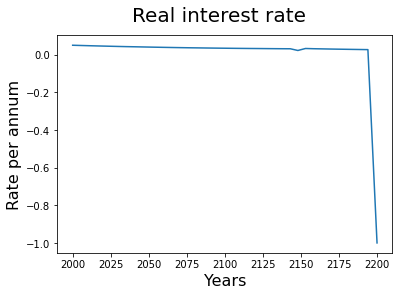

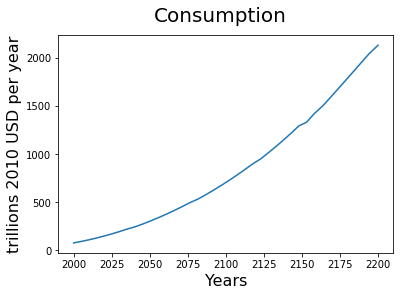

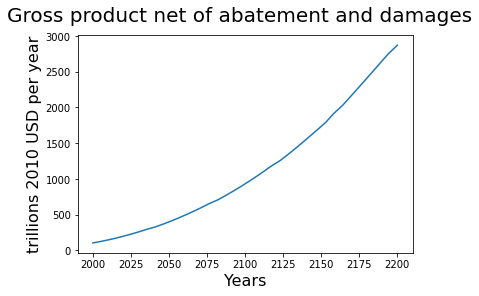

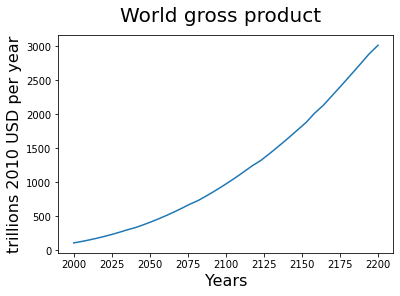

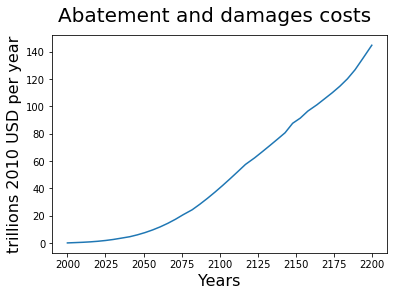

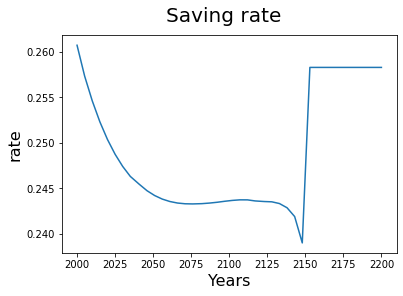

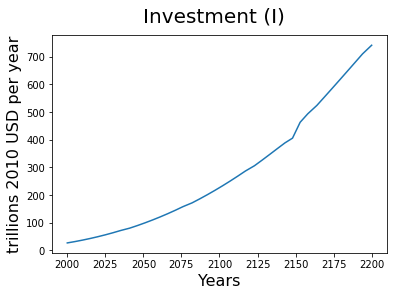

In [407]:
   
    figRI = plt.figure()
    plt.plot(TT,RI)
    figRI.suptitle('Real interest rate', fontsize=20)
    plt.xlabel('Years', fontsize=16)
    plt.ylabel('Rate per annum', fontsize=16)
    
    figC = plt.figure()
    plt.plot(TT,C)
    figC.suptitle('Consumption', fontsize=20)
    plt.xlabel('Years', fontsize=16)
    plt.ylabel('trillions 2010 USD per year', fontsize=16)
    
    figY = plt.figure()
    plt.plot(TT,Y)
    figY.suptitle('Gross product net of abatement and damages', fontsize=20)
    plt.xlabel('Years', fontsize=16)
    plt.ylabel('trillions 2010 USD per year', fontsize=16)
    
    figYGROSS = plt.figure()
    plt.plot(TT,YGROSS)
    figYGROSS.suptitle('World gross product', fontsize=20)
    plt.xlabel('Years', fontsize=16)
    plt.ylabel('trillions 2010 USD per year', fontsize=16)
    
    figYGROSSbyY = plt.figure()
    plt.plot(TT,YGROSS-Y)
    figYGROSSbyY.suptitle('Abatement and damages costs', fontsize=20)
    plt.xlabel('Years', fontsize=16)
    plt.ylabel('trillions 2010 USD per year', fontsize=16)
    
    figS = plt.figure()
    plt.plot(TT,result.x[NT:(2*NT)])
    figS.suptitle('Saving rate', fontsize=20)
    plt.xlabel('Years', fontsize=16)
    plt.ylabel('rate', fontsize=16)
    
    figI = plt.figure()
    plt.plot(TT,I)
    figI.suptitle('Investment (I)', fontsize=20)
    plt.xlabel('Years', fontsize=16)
    plt.ylabel('trillions 2010 USD per year', fontsize=16)
    
    plt.show()